# Time series I: Fourier Transform

Fourier analysis is the study of the way general functions may be represented or approximated by sums of simpler trigonometric functions. By decomposing a function in this sum we can get informations about the frequency of the period of these functions.
When we do a Fourier transform of a function of time, we decompose it into the frequencies that make it up.

$$ \hat{f}(\omega) = \int_{-\infty}^{\infty} f(t)\ e^{- 2\pi i x \omega}\,dt $$

## Discrete Fourier Transform (DFT)
Discrete-time Fourier transform (DTFT) is a form of Fourier analysis that is applicable to uniformly-spaced samples of a continuous function. The term discrete-time refers to the fact that the transform operates on discrete data (samples) whose interval often has units of time.

$$ F(\omega) = \sum_{n=0}^{N-1} x[n] \,e^{-i \omega n} $$

### Example:


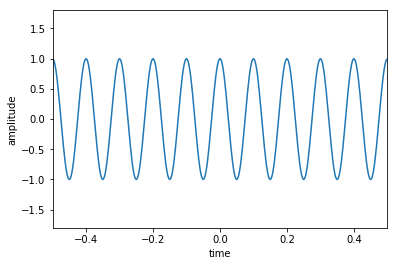

In [134]:
import matplotlib.pyplot as plt
import numpy as np
fs = 400
t = np.arange(-.5, .5, 1.0/fs)
f0 = 10
phi = np.pi/2
A =  1
x = A * np.sin(2 * np.pi * f0 * t + phi)
plt.plot(t, x)
plt.axis([-.5, .5, -1.8, 1.8])
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()

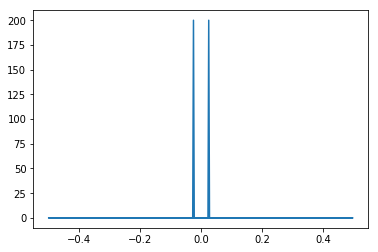

In [135]:
DFT = np.fft.fft(x)
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, np.abs(DFT))
plt.show()


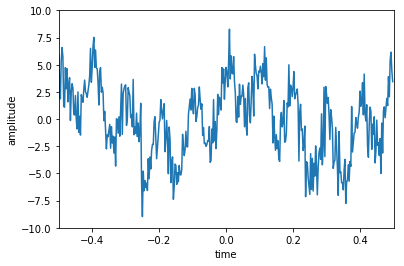

In [136]:
f1 = 10
f2 = 2

phi_1 = np.pi/3
phi_2 = np.pi/4

B = 2
C = 3
D = 4
noise = D*np.random.normal(0,.4,400)

# 0 is the mean of the normal distribution you are choosing from
# 4 is the standard deviation of the normal distribution
# 400 is the number of elements you get in array noise

S = A*np.sin(2*np.pi*f0*t + phi) + B*np.sin(2*np.pi*f1*t + phi_1) + C*np.sin(2*np.pi*f2*t + phi_2) + noise

plt.plot(t, S)
plt.axis([-.5, .5, -10, 10])
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()

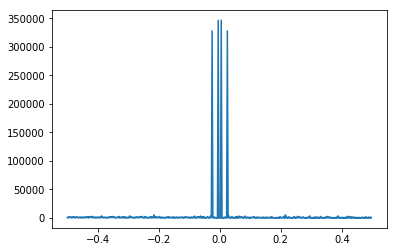

In [137]:
DFT = np.fft.fft(S)
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, np.abs(DFT) ** 2)
plt.show()

## Real signal
The Fourier Transform of a real signal is Hermitian-symmetric: the negative frequency terms are the complex conjugate of the positive frequency terms. This is why the package **`numpy.fft`** includes an optimized version of the DFT --- **`rfft`** --- that returns only half the terms. Also, the term $\frac{1}{N}$ in the DFT formula is not used by default. This is added by `norm="ortho"`.

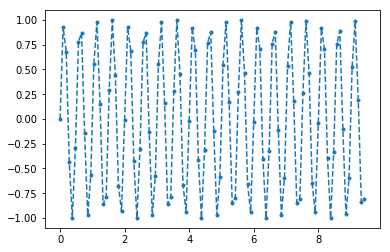

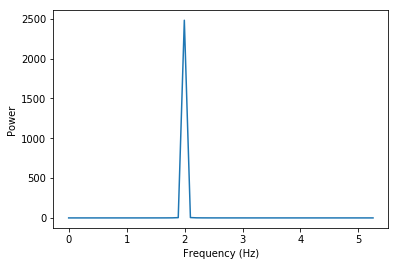

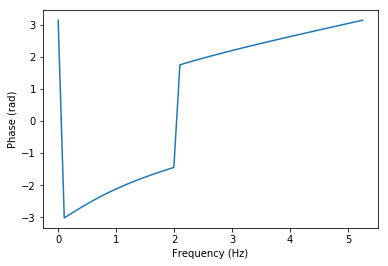

In [138]:
duration = 3 * np.pi
period = 0.5
n_samples = 100

t = np.linspace(0, duration, n_samples)
signal = np.sin(2 * np.pi * t / period)
plt.plot(t, signal, ".--")
plt.show()

DFT = np.fft.rfft(signal)
freq = np.fft.rfftfreq(n=signal.size, d=t[1]-t[0])
power_spectrum = np.abs(DFT) ** 2.0
phase_spectrum = np.angle(DFT)

plt.plot(freq, power_spectrum, "-")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.show()
plt.plot(freq, phase_spectrum, "-")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (rad)")
plt.show()

## Hands-on Fourier Transform
### Let's automate the procedure...
Let's try to generalize the above by defining some functions that will allow us to create signals of multiple components and easily perform Discrete Fourier Transform:

- `get_spectra` takes a signal as input and returns the frequencies, the power and phase spectra of the **real** DFT
- `sinus` creates a sinusoidal signal of **n** points of a specific **amplitude**, **period** (in *points*) and a phase (in radians)
- `noise` creates Gaussian noise of **n** points of certain **amplitude***
- `reconstruct` is fed with the number of points, the power and the phase spectrum and returns the signal in time space

In [139]:
def get_spectra(signal):
    """Returns the power and phase spectra of the Discrete Fourier Transform of a real 'signal' """
    transform = np.fft.rfft(signal)
    frequencies = np.fft.rfftfreq(signal.size)
    power_spectrum = np.abs(transform) ** 2
    phase_spectrum = np.angle(transform)
    return frequencies, power_spectrum, phase_spectrum

def sinus(n_points, amplitude, period, phase):
    """Returns a sinusoidal signal of 'n_points' number of points with specific
    'amplitude', 'period' (in sampling intervals) and 'phase' (in radians)
    """
    return amplitude * np.sin(np.arange(n_points) * (2 * np.pi / period) + phase)

def noise(n_points, amplitude):
    return np.random.normal(scale=amplitude, size=n_points)

def reconstruct(n, frequencies, powers, phases):
    """Returns the signal that corresponds to the power and phase specta 'powers', 'phases' respectively."""
    amplitudes = powers ** 0.5
    signal = np.zeros(n)
    for i in range(1, len(amplitudes)):
        if frequencies[i] == 0.0:
            signal += amplitudes[i]
        else:
            signal += sinus(n, 2 * amplitudes[i], 1 / frequencies[i], phases[i] + np.pi / 2.0)
    signal = signal / n
    return signal


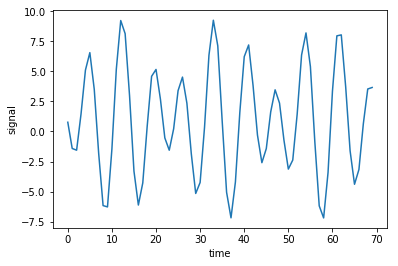

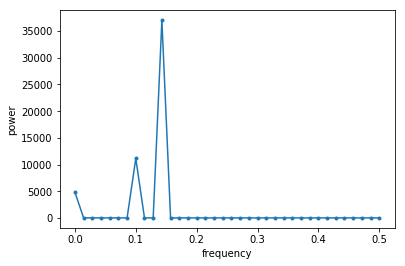

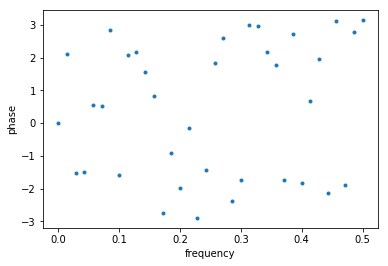

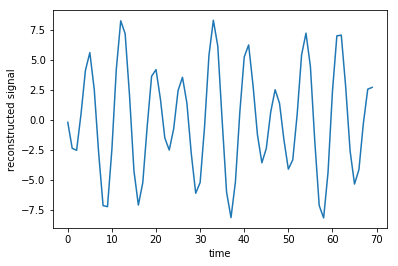

In [140]:
n = 70
t = np.arange(n)
signal = 1.0 + sinus(n, 3.0, 10.0, 0.0) + sinus(n, 5.5, 7.0, np.pi) + noise(n, 0.1)
freqs, power_spectrum, phase_spectrum = get_spectra(signal)
reconstructed_signal = reconstruct(n, freqs, power_spectrum, phase_spectrum)

plt.plot(t, signal, "-")
plt.xlabel("time"); plt.ylabel("signal")
plt.show()

plt.plot(freqs, power_spectrum, ".-")
plt.xlabel("frequency"); plt.ylabel("power")
plt.show()

plt.plot(freqs, phase_spectrum, ".")
plt.xlabel("frequency"); plt.ylabel("phase")
plt.show()

plt.plot(t, reconstructed_signal, "-")
plt.xlabel("time"); plt.ylabel("reconstructed signal")
plt.show()

## FT of random sample

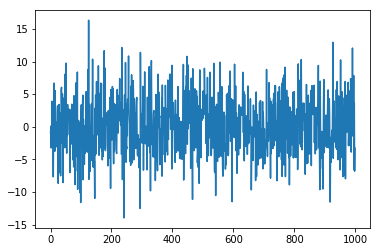

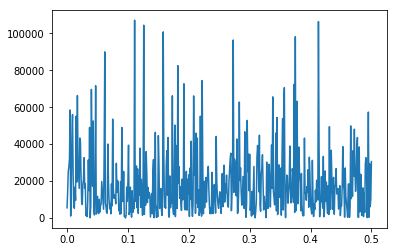

In [141]:
signal = noise(1000, 4.5)
plt.plot(signal)
plt.show()

freq, power, phase = get_spectra(signal)
plt.plot(freq, power)
plt.show()


## Real data
One of the classic examples of timeseries is the yearly measured Wolf's sunspot number. It is known that the solar activity has a cycle of about $11$ years. Are we going to find this periodicity using DFT?

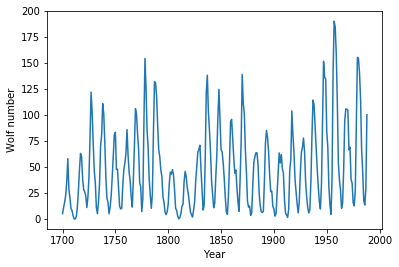

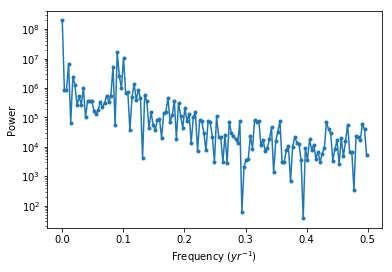

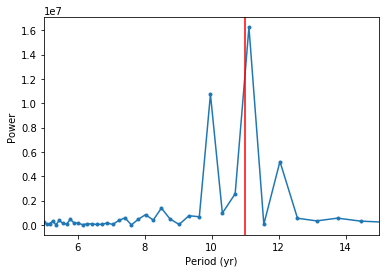

In [142]:
wolf = np.loadtxt("sunspots.txt")
year = 1700 + np.arange(len(wolf))
plt.plot(year, wolf)
plt.xlabel("Year")
plt.ylabel("Wolf number")
plt.show()

freqs, power, phase = get_spectra(wolf)
plt.plot(freqs, power, ".-")
plt.xlabel("Frequency ($yr^{-1}$)"); plt.ylabel("Power")
plt.yscale("log")
plt.show()

# plot power vs period - ignore the constant term to avoid infinity. Focus on t ~ 11yr.
plt.plot(1.0 / freqs[1:], power[1:], ".-")
plt.axvline(11, color="r")
plt.xlim([5.0, 15.0])
plt.xlabel("Period (yr)"); plt.ylabel("Power")
#plt.xscale("log")
plt.show()

## Approximating timeseries using $N$ Fourier terms
Remember that a signal is information, and the power of signal is amount of information. For example, when the signal-to-noise ratio is very low, there isn't much to say about the data. The power spectum informs us at which frequencies most of the power - information - resides. What if we discard all but the $N$ most important frequencies? Will that allows us to reconstruct the signal?

Using frequencies: [ 0.03460208  0.02076125  0.11764706  0.01730104  0.09342561  0.08304498
  0.01038062  0.10034602  0.0899654   0.        ]


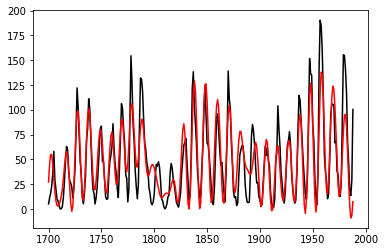

In [143]:
# Select only N significant terms

N = 10
ascending_indices = np.argsort(power)
significant = ascending_indices[-N:]

new_freqs = freqs[significant]
new_power = power[significant]
new_phase = phase[significant]
print "Using frequencies:", new_freqs

approximation = reconstruct(len(year), new_freqs, powers=new_power, phases=new_phase)
plt.plot(year, wolf, "k-")
plt.plot(year, approximation, "r-")
plt.show()